In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import time

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url, sep=';')

data = data[data['total sulfur dioxide']<200]

cols_to_z_score = data.keys()
cols_to_z_score = cols_to_z_score.drop('quality')

# for col in cols_to_z_score:
#     meanval = np.mean(data[col])
#     stdev = np.std(data[col], ddof=0)
#     data[col] = (data[col]-meanval) / stdev
data[cols_to_z_score] = data[cols_to_z_score].apply(stats.zscore)   

data['bool_quality'] = 0
data['bool_quality'][data['quality']>5] = 1


/tmp/ipykernel_5611/753449408.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bool_quality'][data['quality']>5] = 1


In [3]:
dataT = torch.tensor(data[cols_to_z_score].values).float()
labels = torch.tensor(data['bool_quality'].values).float()

labels = labels[:, None]

train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size=.1)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [4]:
class ANNWine_with_BNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input = nn.Linear(11, 16)
        
        self.fc1 = nn.Linear(16, 32)
        self.bnorm1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(32, 20)
        self.bnorm2 = nn.BatchNorm1d(32)
        
        self.output = nn.Linear(20, 1)
        
    def forward(self, x, doBN):
        x = F.relu(self.input(x))
        
        if doBN:
            x = self.bnorm1(x)
            x = self.fc1(x)
            x = F.relu(x)
            
            x = self.bnorm2(x)
            x = self.fc2(x)
            x = F.relu(x)
        else:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
        return self.output(x)
        

In [5]:
num_of_epochs = 1000

def train_model(doBN=True):
    loss_func = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)
    
    train_acc = []
    test_acc = [] 
    losses = torch.zeros(num_of_epochs)
    
    for epoch in range(num_of_epochs):
        model.train()
        batch_acc = []
        batch_loss = []
        for X, y in train_loader:
            yHat = model(X, doBN)
            loss = loss_func(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            predlabels = yHat>0
            batch_acc.append(100*torch.mean((predlabels==y).float()).item())
            batch_loss.append(loss.item())
            
        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)
        
        model.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            predlabels = model(X, doBN)>0
        test_acc.append(100*torch.mean((predlabels==y).float()).item())
    
    return train_acc, test_acc, losses

In [6]:
model = ANNWine_with_BNorm()
train_acc_no, test_acc_no, losses_no = train_model(False)

model = ANNWine_with_BNorm()
train_acc_with, test_acc_with, losses_with = train_model(True)

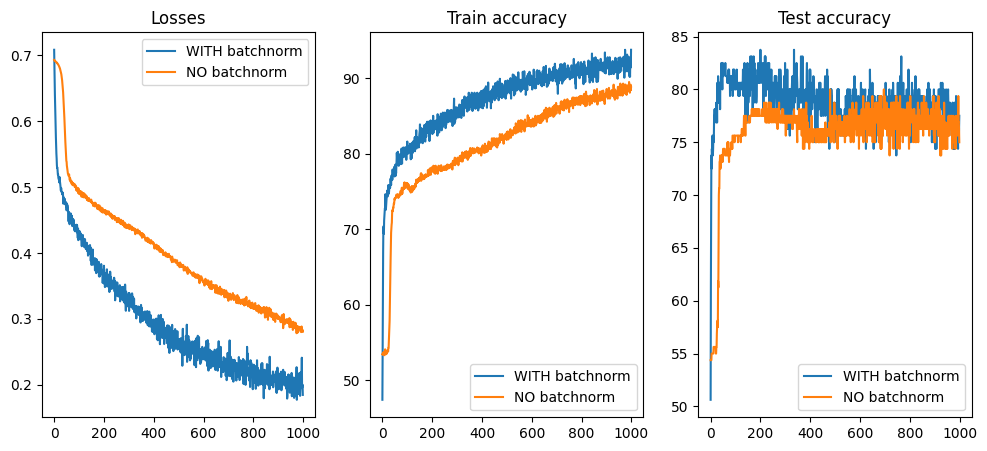

In [7]:
fig, ax = plt.subplots(1,3,figsize=(12,5))

ax[0].plot(losses_with, label='WITH batchnorm')
ax[0].plot(losses_no, label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(train_acc_with, label='WITH batchnorm')
ax[1].plot(train_acc_no, label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(test_acc_with, label='WITH batchnorm')
ax[2].plot(test_acc_no, label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()